---

# Ансамбли моделей

В этой работе мы рассмотрим применение некоторых классических и хорошо себя показавших алгоритмов-ансамблей. Демонстрировать работу этих алгоритмов будем на данных о потреблении электричества.

# Описание набора данных

**Author**: M. Harries, J. Gama, A. Bifet  
**Source**: [Joao Gama](http://www.inescporto.pt/~jgama/ales/ales_5.html) - 2009  
**Please cite**: None  

**Electricity** is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends).

The data was normalized by A. Bifet.

### Attribute information  
* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
* Day: day of the week (1-7)
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
* NSWprice: New South Wales electricity price, normalized between 0 and 1
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1
* VICprice: Victoria electricity price, normalized between 0 and 1
* VICdemand: Victoria electricity demand, normalized between 0 and 1
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1

### Relevant papers  
M. Harries. Splice-2 comparative evaluation: Electricity pricing. Technical report, The University of South Wales, 1999.  
J. Gama, P. Medas, G. Castillo, and P. Rodrigues. Learning with drift detection. In SBIA Brazilian Symposium on Artificial Intelligence, pages 286–295, 2004.

# Разведочный анализ данных

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

Считайте набор данных в датафрейм

In [61]:
df = pd.read_csv('https://dc-edu.itmo.ru/assets/courseware/v1/cc35e5628f3a2988c98dbca1b8b5969c/asset-v1:ITMO+bonus_track_methods+2023+type@asset+block/electricity_train.csv')
df

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.425556,6,0.723404,0.076258,0.311366,0.003467,0.422915,0.414912,1
1,0.867351,7,0.808511,0.028131,0.299018,0.001838,0.325738,0.832018,0
2,0.031680,1,0.723404,0.055242,0.398691,0.003467,0.422915,0.414912,0
3,0.867793,3,1.000000,0.028822,0.396162,0.001014,0.394873,0.639474,0
4,0.880536,4,0.978723,0.040741,0.468908,0.002655,0.425427,0.630702,1
...,...,...,...,...,...,...,...,...,...
36244,0.447281,2,0.723404,0.087096,0.845879,0.006061,0.687209,0.327632,1
36245,0.429583,7,0.425532,0.058034,0.372657,0.003467,0.422915,0.414912,0
36246,0.013053,5,0.468085,0.041732,0.558465,0.003467,0.422915,0.414912,0
36247,0.889739,3,0.872340,0.078179,0.730586,0.005393,0.599171,0.476754,1


При помощи метода <code>.describe()</code> изучите набор данных «с высоты птичьего полета».

In [62]:
df.describe()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000
mean,0.498293,4.006566,0.500560,0.057828,0.425939,0.003455,0.423024,0.500243,0.424536
std,0.339907,1.993551,0.294998,0.039052,0.163390,0.010175,0.120600,0.153098,0.494279
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031945,2.000000,0.255319,0.035187,0.309729,0.002283,0.373382,0.414912,0.000000
50%,0.456263,4.000000,0.510638,0.048787,0.444213,0.003467,0.422915,0.414912,0.000000
75%,0.880492,6.000000,0.765957,0.074457,0.536745,0.003467,0.468669,0.605263,1.000000
max,1.000000,7.000000,1.000000,1.000000,0.980809,1.000000,1.000000,0.959211,1.000000


Убедитесь в отсутствии пропусков. Имеет смысл проверить сбалансированность классов. Введите долю элементов класса $1$.

In [63]:
# убедимся в отсутствии пропусков
if not(df.isnull().any().any()):
  print('Пропусков нет')

Пропусков нет


In [64]:
# вычислим долю элементов класса 1
print('Доля элементов класса 1:', round(df['class'].value_counts(normalize=True)[1], 3))

Доля элементов класса 1: 0.425


Постройте матрицу корреляций. Определите пару наиболее коррелированных признаков.

In [65]:
# построим матрицу корреляций
corr_matrix = round(df.corr(), 3)
corr_matrix

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
date,1.000,0.006,0.002,-0.154,0.068,0.002,0.057,0.406,-0.004
day,0.006,1.000,-0.000,0.003,-0.053,0.001,0.077,-0.053,-0.047
period,0.002,-0.000,1.000,0.105,0.445,0.023,0.192,-0.115,0.154
nswprice,-0.154,0.003,0.105,1.000,0.307,0.288,0.304,-0.275,0.386
nswdemand,0.068,-0.053,0.445,0.307,1.000,0.084,0.667,-0.264,0.332
vicprice,0.002,0.001,0.023,0.288,0.084,1.000,0.125,-0.081,0.066
vicdemand,0.057,0.077,0.192,0.304,0.667,0.125,1.000,-0.553,0.232
transfer,0.406,-0.053,-0.115,-0.275,-0.264,-0.081,-0.553,1.000,-0.120
class,-0.004,-0.047,0.154,0.386,0.332,0.066,0.232,-0.120,1.000


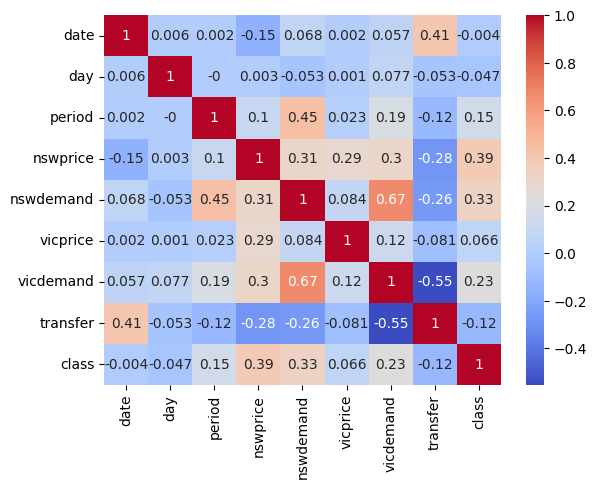

In [66]:
# построим тепловую карту для наглядности
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [67]:
# определим пару наиболее коррелированных признаков
max_correlation, max_correlated = 0, []

for i in range(1, len(corr_matrix)):
  for j in range(i + 1, len(corr_matrix)):
    value = abs(corr_matrix.iloc[i, j])
    if value > max_correlation:
      max_correlation, max_correlated = value, [corr_matrix.index[i], corr_matrix.columns[j]]

print(f'Наиболее коррелируют признаки: {max_correlated[0]}, {max_correlated[1]}')

Наиболее коррелируют признаки: nswdemand, vicdemand


Постройте гистограммы распределений признаков.

In [68]:
# определим количество признаков
len(df.columns) - 1

8

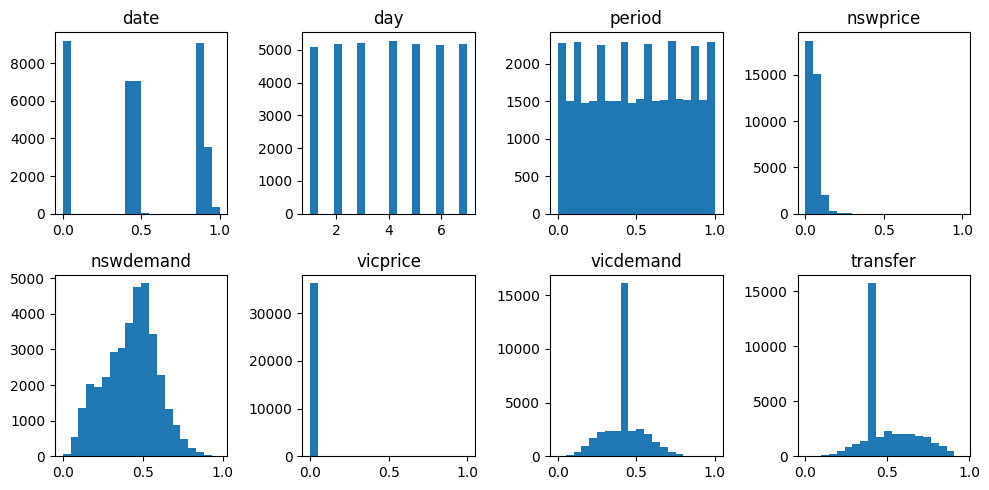

In [69]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))

for ax, column in zip(ax.flat, df.drop(columns='class').columns):
  ax.hist(df[column], bins=20)
  ax.set_title(column)

plt.tight_layout()
plt.show()

Из полученных иллюстраций видно, что в данных, скорее всего, как и ожидалось, есть некоторая периодичность. Более того, похоже, за нас уже поработали над заполнением пропусков или обработкой выбросов

При помощи <code>train_test_split</code> разобейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [70]:
# разобьем набор данных на тренеровочную и тестовую выборки с параметрами test_size=0.2, random_state=7
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='class'), df['class'], test_size=0.2, random_state=7)

print('Shapes', '    X', '       y')
print('train', X_train.shape, y_train.shape)
print('test ', X_test.shape, y_test.shape)

Shapes     X        y
train (28999, 8) (28999,)
test  (7250, 8) (7250,)


# Random Forests Classifier

Обучите модель <code>sklearn.ensemble.RandomForestClassifier</code> на тренировочных данных с параметрами, указанными в вашем индивидуальном задании.

In [71]:
# обучим модель sklearn.ensemble.RandomForestClassifier на тренировочных данных с параметрами random_state=7
forest = RandomForestClassifier(random_state=7).fit(X_train, y_train)

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [72]:
prediction = forest.predict(X_train)
print(classification_report(y_train, prediction, target_names = ['class 0', 'class 1'], digits=3))

              precision    recall  f1-score   support

     class 0      1.000     1.000     1.000     16705
     class 1      1.000     1.000     1.000     12294

    accuracy                          1.000     28999
   macro avg      1.000     1.000     1.000     28999
weighted avg      1.000     1.000     1.000     28999



Получили переобучение. Что же, еще раз можно ответить, что деревья принятия решений весьма склонны к переобучению.

## Добавление к лесу деревьев GridSearchCV

При помощи <code>sklearn.model_selection.GridSearchCV</code> обучите <code>RandomForestClassifier</code> на тренировочных данных c параметрами, указанными в вашем индивидуальном задании.

Подбираемые параметры:

<code>{'n_estimators': [100,300,500], 'max_leaf_nodes': list(range(6,10)), 'min_samples_leaf': [1,2,3]}</code>

In [73]:
params_grid = {'n_estimators': [100,300,500], 'max_leaf_nodes': list(range(6,10)), 'min_samples_leaf': [1,2,3]}

cv = GridSearchCV(RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced',
                                        n_jobs=-1,
                                        max_features='sqrt',
                                        random_state=7),
                                        params_grid,
                                        verbose=4,
                                        cv=3)
cv.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.765 total time=   2.8s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.777 total time=   1.4s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.776 total time=   1.3s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.769 total time=   3.9s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.776 total time=   4.1s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.776 total time=   5.5s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.770 total time=   6.5s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.777 total time=   8.3s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.776 total time=   6.3s
[CV 1/3] END max_leaf_nodes=6

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              class_weight='balanced',
                                              n_jobs=-1, random_state=7),
             param_grid={'max_leaf_nodes': [6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 300, 500]},
             verbose=4)

Выберите лучшую модель. Рекомендуем использовать поле <code>best_estimator_</code> объекта класса <code>grid_search</code>. В поле <code>best_params_</code> этого же объекта можно найти параметры лучшей модели.

In [74]:
# выберем лучшую модель
forest_cv = cv.best_estimator_

In [75]:
# найдем параметры лучшей модели
cv.best_params_

{'max_leaf_nodes': 9, 'min_samples_leaf': 1, 'n_estimators': 100}

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [76]:
prediction_train = forest_cv.predict(X_train)
print(classification_report(y_train, prediction_train, target_names = ['class 0', 'class 1'], digits=3))

              precision    recall  f1-score   support

     class 0      0.785     0.869     0.825     16705
     class 1      0.792     0.677     0.730     12294

    accuracy                          0.788     28999
   macro avg      0.789     0.773     0.778     28999
weighted avg      0.788     0.788     0.785     28999



Постройте <code>classification_report</code> полученной модели на **тестовых данных**. Введите значение точности модели на **тестовых данных**.

In [77]:
prediction_test = forest_cv.predict(X_test)
print(classification_report(y_test, prediction_test, target_names = ['class 0', 'class 1'], digits=3))

              precision    recall  f1-score   support

     class 0      0.784     0.864     0.822      4155
     class 1      0.789     0.680     0.731      3095

    accuracy                          0.786      7250
   macro avg      0.786     0.772     0.776      7250
weighted avg      0.786     0.786     0.783      7250



От переобучения избавились, но точность кажется низкой.

Один из плюсов случайного леса — можно посмотреть на важность признаков при классификации (обратная задача). Значения важности можно найти в поле <code>feature_importances_</code> модели. Определите название самого важного признака модели.

In [78]:
important = forest.feature_importances_
index = np.where(important == max(important))
print('Самый важный признак модели:', df.columns[index][0])

Самый важный признак модели: nswprice


Попробуем улучшить результаты, используя другие виды ансамблей.

# Voting Classifier

Обучает все модели, поданные на вход, и предсказывает финальный результат либо по большему числу одинаковых ответов, которые дали модели (hard), либо вычисляет вероятность отнесения объектов к классам по всем моделям и берет argmax.

Используйте объект <code>sklearn.ensemble.VotingClassifier</code> с параметром <code>voting='hard'</code>. В качестве базовых алгоритмов используйте классификаторы с соответствующими параметрами, указанными в вашем индивидуальном задании. Обучите модель на тренировочных данных

In [79]:
estimators = [('Logistic Regression',LogisticRegression(solver='liblinear', random_state=7)),
              ('SVM', SVC(random_state=7)),
              ('SGDClassifier', SGDClassifier(random_state=7))]

vote = VotingClassifier(estimators, voting='hard').fit(X_train, y_train)

Вычислите точность модели на **тренировочных данных**

In [80]:
prediction_train = vote.predict(X_train)
print(classification_report(y_train, prediction_train, target_names = ['class 0', 'class 1'], digits=3))

              precision    recall  f1-score   support

     class 0      0.735     0.895     0.807     16705
     class 1      0.797     0.561     0.658     12294

    accuracy                          0.753     28999
   macro avg      0.766     0.728     0.733     28999
weighted avg      0.761     0.753     0.744     28999



Вычислите точность модели на **тестовых данных**

In [81]:
prediction_test = vote.predict(X_test)
print(classification_report(y_test, prediction_test, target_names = ['class 0', 'class 1'], digits=3))

              precision    recall  f1-score   support

     class 0      0.731     0.890     0.803      4155
     class 1      0.792     0.561     0.657      3095

    accuracy                          0.750      7250
   macro avg      0.762     0.726     0.730      7250
weighted avg      0.757     0.750     0.741      7250



# Bagging Classifier

Создает несколько объектов одного класса (несколько моделей) и обучает их на непересекающихся подмножествах тренировочных данных, а дальше усредняет ответы.

На основе <code>sklearn.ensemble.BaggingClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [82]:
bag = BaggingClassifier(
    DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5,
    max_features=0.5,
    bootstrap=False,
    random_state=7)
bag.fit(X_train, y_train)

BaggingClassifier(bootstrap=False,
                  estimator=DecisionTreeClassifier(class_weight='balanced'),
                  max_features=0.5, max_samples=0.5, random_state=7)

Вычислите точность модели на **тренировочных данных**

In [83]:
prediction_train = bag.predict(X_train)
print(classification_report(y_train, prediction_train, target_names = ['class 0', 'class 1'], digits=3))

              precision    recall  f1-score   support

     class 0      0.973     0.993     0.983     16705
     class 1      0.990     0.963     0.976     12294

    accuracy                          0.980     28999
   macro avg      0.981     0.978     0.979     28999
weighted avg      0.980     0.980     0.980     28999



Вычислите точность модели на **тестовых данных**

In [85]:
prediction_test = bag.predict(X_test)
print(classification_report(y_test, prediction_test, target_names = ['class 0', 'class 1'], digits=3))

              precision    recall  f1-score   support

     class 0      0.842     0.922     0.880      4155
     class 1      0.880     0.767     0.820      3095

    accuracy                          0.856      7250
   macro avg      0.861     0.845     0.850      7250
weighted avg      0.858     0.856     0.854      7250



# Gradient Boosting Classifier

Градиентный бустинг работает примерно так: создается несколько объектов класса (несколько моделей), они выстраиваются в цепочку так, чтобы каждый следующий пытался исправить ошибки предыдущего. Склонен к переобучению.

Обучите модель на основе <code>sklearn.ensemble.GradientBoostingClassifier</code> с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [86]:
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.8, random_state=7, max_depth=2).fit(X_train, y_train)

Вычислите точность модели на **тренировочных данных**

In [87]:
prediction_train = gb.predict(X_train)
print(classification_report(y_train, prediction_train, target_names = ['class 0', 'class 1'], digits=3))

              precision    recall  f1-score   support

     class 0      0.936     0.943     0.940     16705
     class 1      0.922     0.913     0.918     12294

    accuracy                          0.931     28999
   macro avg      0.929     0.928     0.929     28999
weighted avg      0.930     0.931     0.930     28999



Вычислите точность модели на **тестовых данных**

In [88]:
prediction_test = gb.predict(X_test)
print(classification_report(y_test, prediction_test, target_names = ['class 0', 'class 1'], digits=3))

              precision    recall  f1-score   support

     class 0      0.912     0.919     0.915      4155
     class 1      0.890     0.880     0.885      3095

    accuracy                          0.903      7250
   macro avg      0.901     0.900     0.900      7250
weighted avg      0.903     0.903     0.903      7250



# AdaBoost Classifier

Работает похожим на градиентный бустинг образом, только последующие модели не пытаются исправить ошибку предыдущих: сначала первый объект обучается на всем датасете, а следующий на основе опыта предыдущего обновляет свои веса так, чтобы исправлять ошибочные предсказания.

На основе <code>sklearn.ensemble.AdaBoostClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [90]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=300,
    learning_rate=0.5,
    random_state=7)
ada.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=3),
                   learning_rate=0.5, n_estimators=300, random_state=7)

Вычислите точность модели на **тренировочных данных**

In [91]:
prediction_train = ada.predict(X_train)
print(classification_report(y_train, prediction_train, target_names = ['class 0', 'class 1'], digits=3))

              precision    recall  f1-score   support

     class 0      0.961     0.938     0.949     16705
     class 1      0.919     0.948     0.933     12294

    accuracy                          0.942     28999
   macro avg      0.940     0.943     0.941     28999
weighted avg      0.943     0.942     0.942     28999



Вычислите точность модели на **тестовых данных**

In [92]:
prediction_test = ada.predict(X_test)
print(classification_report(y_test, prediction_test, target_names = ['class 0', 'class 1'], digits=3))

              precision    recall  f1-score   support

     class 0      0.925     0.900     0.912      4155
     class 1      0.871     0.901     0.886      3095

    accuracy                          0.901      7250
   macro avg      0.898     0.901     0.899      7250
weighted avg      0.902     0.901     0.901      7250



# Stacking Classifier

Обучает несколько объектов класса (несколько моделей) на всем наборе данных, а после — обучает отдельный классификатор на метданных — ответах, полученных обученными ранее моделями.

Используйте объект <code>sklearn.ensemble.StackingClassifier</code>. Базовые алгоритмы и решающий, а также соответствующие параметры указанны в вашем индивидуальном задании. Обучите модель на тренировочных данных.

In [96]:
estimators = [('Random Forest', RandomForestClassifier(random_state=7)),
              ('SVM', SVC(random_state=7))]
final_estimator = LogisticRegression(random_state=7)

stack = StackingClassifier(estimators=estimators, final_estimator=final_estimator).fit(X_train, y_train)

Вычислите точность модели на **тренировочных данных**

In [97]:
prediction_train = stack.predict(X_train)
print(classification_report(y_train, prediction_train, target_names = ['class 0', 'class 1'], digits=3))

              precision    recall  f1-score   support

     class 0      1.000     1.000     1.000     16705
     class 1      1.000     0.999     1.000     12294

    accuracy                          1.000     28999
   macro avg      1.000     1.000     1.000     28999
weighted avg      1.000     1.000     1.000     28999



Вычислите точность модели на **тестовых данных**

In [98]:
prediction_test = stack.predict(X_test)
print(classification_report(y_test, prediction_test, target_names = ['class 0', 'class 1'], digits=3))

              precision    recall  f1-score   support

     class 0      0.915     0.924     0.920      4155
     class 1      0.897     0.885     0.891      3095

    accuracy                          0.908      7250
   macro avg      0.906     0.905     0.905      7250
weighted avg      0.907     0.908     0.908      7250

